# 1. Install required packages

In [60]:
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 2. Collect data

In [61]:

vale = yf.download('VALE3.SA', start="2025-04-01", end="2025-05-10")
vale.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VALE3.SA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA
Date,,,,,,


In [62]:
vale = pd.read_csv('/Users/jeffsantos/Desktop/9DTSR/git/9DTSR/Reinforcement Learning/Trabalho Integrado/vale.csv')
vale.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,33.844028,33.912549,33.482725,33.626000,17509700
1,2020-01-03,33.594856,33.949929,33.376830,33.439123,17284800
2,2020-01-06,33.395515,33.513872,33.108966,33.513872,32787800
3,2020-01-07,33.638454,33.756811,33.264695,33.326987,16326400
4,2020-01-08,33.644684,33.868941,33.401740,33.763043,15298500


In [63]:
petro = yf.download('PETR4.SA', start="2020-01-01", end="2025-04-27")
petro.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PETR4.SA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,


In [64]:
brfood = yf.download('BRFS3.SA', start="2020-01-01", end="2025-04-27")
brfood.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRFS3.SA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BRFS3.SA,BRFS3.SA,BRFS3.SA,BRFS3.SA,BRFS3.SA,BRFS3.SA
Date,,,,,,


# 3. Data Preparation

## 3.1 Vale

In [65]:
#Checking for any null values and removing the null values'''
print('Null Values =',vale.isnull().values.any())

# Fill the missing values with the last value available in the dataset. 
vale=vale.bfill()

# Selecting the columns we need
#df_vale = vale[[('Close', 'VALE3.SA')]].reset_index()
df_vale = vale[['Date', 'Close']][vale['Date'] >= '2024-04-01'].copy()

df_vale.head(2)


Null Values = False


,Date,Close
1054,2024-04-01,56.340973
1055,2024-04-02,57.003590


In [66]:
#Checking for any null values and removing the null values'''
print('Null Values =',petro.isnull().values.any())

# Fill the missing values with the last value available in the dataset. 
petro=petro.bfill()
petro.head(2)

Null Values = False


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,


In [67]:
#Checking for any null values and removing the null values'''
print('Null Values =',brfood.isnull().values.any())

# Fill the missing values with the last value available in the dataset. 
brfood=petro.bfill()
brfood.head(2)

Null Values = False


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,


# 4. Creating a Model

## 4.1 Criando o ambiente

In [155]:
import numpy as np

class TradingEnvironment:
    def __init__(self, data, initial_balance=10000):
        self.data = data.reset_index(drop=True)  # Garantir indexação simples
        self.initial_balance = initial_balance
        self.transaction_fee_percent = 0.001  # 0.1%
        self.reset()
    
    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 5  # Começa em 5 por causa da variação de D-5
        self.done = False
        self.total_profit = 0
        self.invalid_action = False
        self.portfolio_value = self.initial_balance
        return self._get_state()
    
    def _get_state(self):
        price = self.data.iloc[self.current_step]
        return np.array([price, self.balance, self.shares_held], dtype=np.float32)
    
    def step(self, action):
        price = self.data.iloc[self.current_step]
        reward = 0

        # Armazena valor do portfólio antes da ação
        prev_portfolio_value = self.balance + self.shares_held * price
        
        # Ações com custo de transação
        if action == 0:  # Comprar
            max_shares = int(self.balance // (price * (1 + self.transaction_fee_percent)))
            if max_shares > 0:
                total_cost = max_shares * price * (1 + self.transaction_fee_percent)
                self.shares_held += max_shares
                self.balance -= total_cost
            else:
                self.invalid_action = True
                reward += 0.1
        
        elif action == 1:  # Vender
            if self.shares_held > 0:
                total_revenue = self.shares_held * price * (1 - self.transaction_fee_percent)
                self.balance += total_revenue
                self.shares_held = 0
            else:
                self.invalid_action = True
                reward += 0.1
        
        # Atualização da etapa
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True
        
        # Valor atual do portfólio
        current_price = self.data.iloc[self.current_step]
        self.portfolio_value = self.balance + (self.shares_held * current_price)
        
        # Penalidade por ficar parado
        if action == 2:
            reward -= 0.5

        # Recompensa: mudança no valor do portfólio
        delta_current = (self.portfolio_value - prev_portfolio_value) / self.initial_balance
        delta_total = (self.portfolio_value - self.initial_balance) / self.initial_balance
        reward += 0.10 * delta_current + 0.90 * delta_total

        state = self._get_state()
        return state, reward, self.done, {}


## 4.2 Criando a rede neural

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import random

In [70]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_size)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

## 4.3 Criando a política de ação

In [71]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size=32, memory_size=50000):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []  # Replay buffer
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.model = QNetwork(state_size, action_size)
        self.target_model = QNetwork(state_size, action_size)
        self.update_target_network()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.SmoothL1Loss()
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.gamma = 0.99
    
    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def store_experience(self, state, action, reward, next_state, done):
        # Verifica se os estados têm a mesma forma
        if len(state) != len(next_state):
            raise ValueError("Os estados (state e next_state) têm formas diferentes.")
        self.memory.append((state, action, reward, next_state, done))
    
    def train(self):
        if len(self.memory) < self.batch_size:
            return
    
        # Amostra um batch aleatório de experiências
        batch = random.sample(self.memory, self.batch_size)
        
        for state, action, reward, next_state, done in batch:
            # Converte cada elemento para tensores PyTorch
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            action = torch.tensor(action, dtype=torch.long).unsqueeze(0)
            reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)
            done = torch.tensor(done, dtype=torch.float32).unsqueeze(0)
            
            # Q-value atual
            q_values = self.model(state)
            q_value = q_values[0][action]
            
            # Q-value futuro (do target network)
            next_q_values = self.target_model(next_state)
            next_q_value = torch.max(next_q_values)
            
            # Calcula o valor alvo
            target = reward + (self.gamma * next_q_value * (1 - done))
            
            # Perda (loss)
            loss = self.criterion(q_value, target)
            
            # Retropropagação
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        # Atualiza a rede target periodicamente
        self.update_target_network()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # Ação aleatória (exploração)
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = self.model(state)
            return torch.argmax(q_values).item()  # Ação com maior Q-value (exploração)
    
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [149]:
import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

class DQNAgent:
    def __init__(self, state_size, action_size, batch_size=128, memory_size=50000, target_update_freq=100):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = 0.90

        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        self.memory = deque(maxlen=memory_size)
        self.model = QNetwork(state_size, action_size)
        self.target_model = QNetwork(state_size, action_size)
        self.update_target_network()

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.SmoothL1Loss()

        self.train_step = 0
        self.target_update_freq = target_update_freq

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        # Q-atual
        q_values = self.model(states).gather(1, actions)

        # Q-futuro do target
        next_q_values = self.target_model(next_states).max(1)[0].unsqueeze(1)
        target = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.criterion(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Atualiza a target network a cada N passos
        self.train_step += 10 #ajustar
        if self.train_step % self.target_update_freq == 0:
            self.update_target_network()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# 4.4 Simular e treinar o Agente

In [73]:
df_vale

,Date,Close
1054,2024-04-01,56.340973
1055,2024-04-02,57.003590
1056,2024-04-03,56.184521
1057,2024-04-04,55.558712
1058,2024-04-05,54.951317
...,...,...
1325,2025-05-02,52.799999
1326,2025-05-05,52.959999
1327,2025-05-06,53.000000
1328,2025-05-07,52.900002


Episode 10/200 completed with portfolio of 8564. Com sugestão de ação 0 e recompensa -56.2.
Episode 20/200 completed with portfolio of 10105. Com sugestão de ação 2 e recompensa -37.2.
Episode 30/200 completed with portfolio of 8749. Com sugestão de ação 1 e recompensa -39.8.
Episode 40/200 completed with portfolio of 7228. Com sugestão de ação 1 e recompensa -59.1.
Episode 50/200 completed with portfolio of 9609. Com sugestão de ação 0 e recompensa -44.7.
Episode 60/200 completed with portfolio of 10591. Com sugestão de ação 2 e recompensa -11.4.
Episode 70/200 completed with portfolio of 7548. Com sugestão de ação 1 e recompensa -72.1.
Episode 80/200 completed with portfolio of 7641. Com sugestão de ação 0 e recompensa -45.6.
Episode 90/200 completed with portfolio of 10187. Com sugestão de ação 2 e recompensa -35.5.
Episode 100/200 completed with portfolio of 8533. Com sugestão de ação 1 e recompensa -33.4.
Episode 110/200 completed with portfolio of 9735. Com sugestão de ação 1 e r

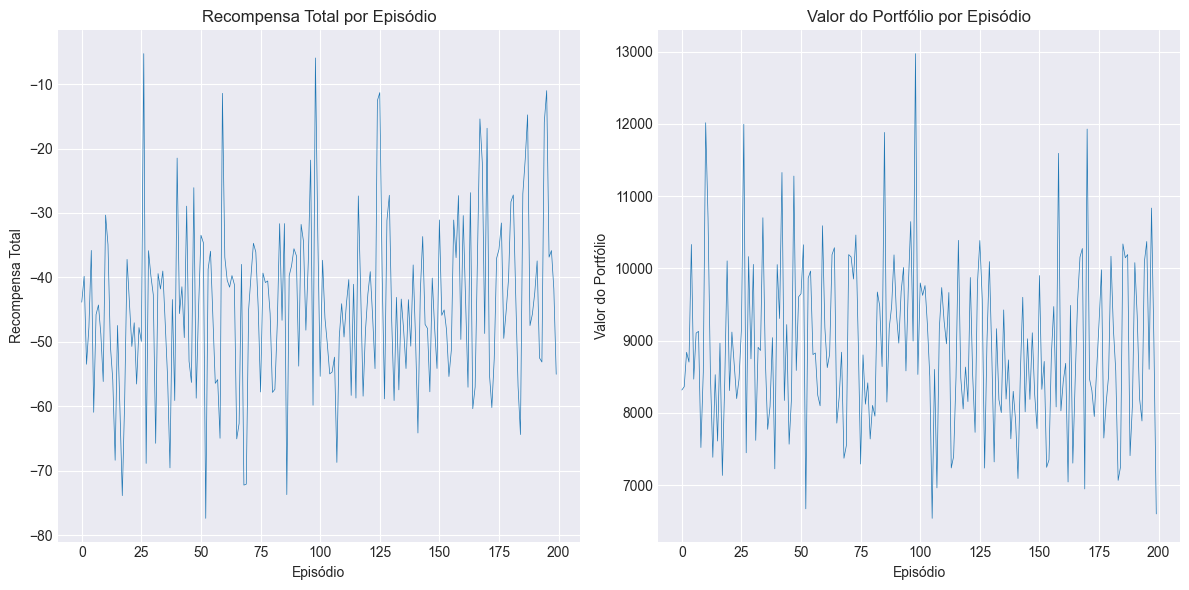

In [156]:
import matplotlib.pyplot as plt

# Definir o tamanho do estado e da ação
state_size = 3  # Preço, saldo, ações
action_size = 3  # Comprar, vender, manter

# Criar o ambiente de negociação
env = TradingEnvironment(df_vale['Close'], initial_balance=10000)

# Criar o agente
agent = DQNAgent(state_size, action_size)

# Listas para armazenar métricas
total_rewards = []  # Para armazenar recompensa total por episódio
portfolio_values = []  # Para armazenar o valor do portfólio no final de cada episódio

# Treinamento
episodes = 200
for episode in range(episodes):
    state = env.reset()
    done = False
    episode_reward = 0  # Recompensa acumulada por episódio
    daily_values_mid = []
    daily_values_final = []
    step_count = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        step_count += 1
        if step_count % 1 == 0:
            agent.train()
        state = next_state
        episode_reward += reward  # Acumulando a recompensa no episódio

        if episode == episodes/2:
            daily_values_mid.append(env.portfolio_value)
            mid_episode_portfolio = daily_values_mid
        if episode == episodes - 1:
            daily_values_final.append(env.portfolio_value)
            last_episode_portfolio = daily_values_final
    
    # Atualizar a exploração
    agent.update_epsilon()
    
    # Armazenar métricas
    total_rewards.append(episode_reward)
    portfolio_values.append(env.portfolio_value)
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{episodes} completed with portfolio of {round(env.portfolio_value)}. Com sugestão de ação {action} e recompensa {round(episode_reward,1)}.")

# Plotar as métricas
plt.figure(figsize=(12, 6))

# Gráfico de recompensa total por episódio
plt.subplot(1, 2, 1)
plt.plot(total_rewards, linewidth=0.5)
plt.title("Recompensa Total por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Recompensa Total")

# Gráfico do valor do portfólio ao longo dos episódios
plt.subplot(1, 2, 2)
plt.plot(portfolio_values, linewidth=0.5)
plt.title("Valor do Portfólio por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Valor do Portfólio")

plt.tight_layout()
plt.show()


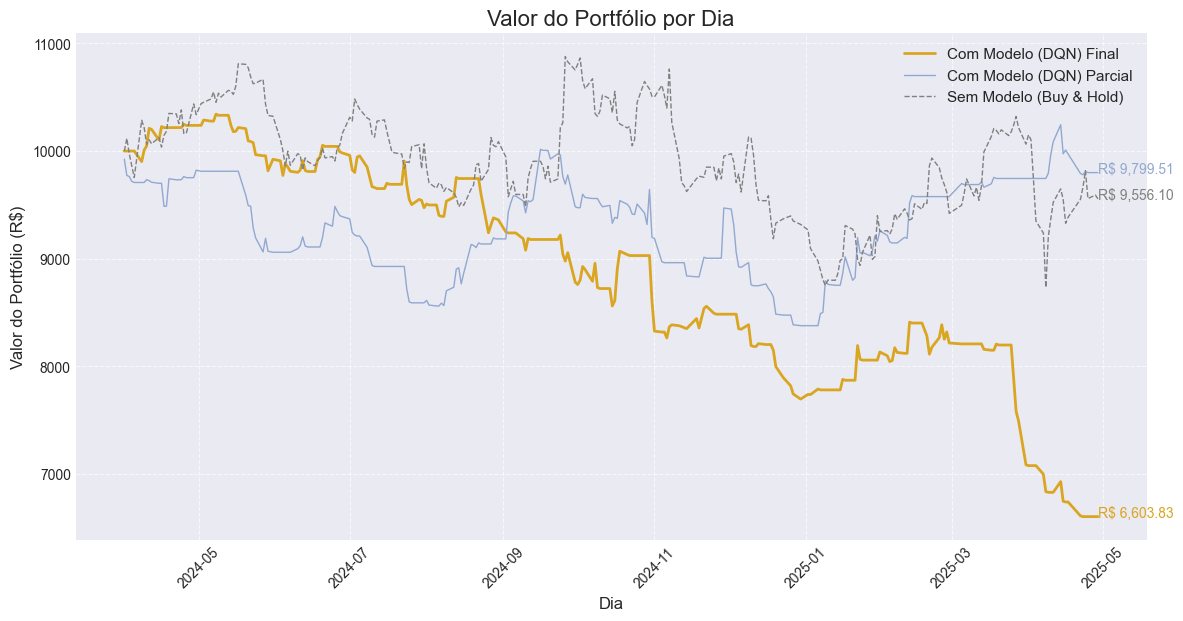

In [157]:
import pandas as pd 

initial_balance = 10000
num_acoes = initial_balance / df_vale['Close'].iloc[0]
portfolio_values_real = df_vale['Close'] * num_acoes

# Garantir que a coluna 'Date' está no formato datetime
df_vale['Date'] = pd.to_datetime(df_vale['Date'])

# Garantir que ambas as listas tenham o mesmo tamanho
min_length = min(len(last_episode_portfolio), len(portfolio_values_real), len(df_vale['Date']))
last_episode_portfolio = last_episode_portfolio[:min_length]
portfolio_values_real = portfolio_values_real[:min_length]
dates = df_vale['Date'][:min_length]

# Estilo do gráfico
plt.style.use('seaborn-v0_8-darkgrid')  

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(dates, last_episode_portfolio, label='Com Modelo (DQN) Final', color='#DAA520', linewidth=2, linestyle='-')
plt.plot(dates, mid_episode_portfolio, label='Com Modelo (DQN) Parcial', color='#91A8D0', linewidth=1, linestyle='-')
plt.plot(dates, portfolio_values_real, label='Sem Modelo (Buy & Hold)', color='gray', linewidth=1, linestyle='--')

# Adicionando título e labels
plt.title("Valor do Portfólio por Dia", fontsize=16)
plt.xlabel("Dia", fontsize=12)
plt.ylabel("Valor do Portfólio (R$)", fontsize=12)

# Adicionando legendas e textos nos pontos finais
plt.legend(loc='best', fontsize=11)
plt.text(dates.iloc[-1], last_episode_portfolio[-1], f'R$ {last_episode_portfolio[-1]:,.2f}', color='#DAA520', fontsize=10)
plt.text(dates.iloc[-1], mid_episode_portfolio[-1], f'R$ {mid_episode_portfolio[-1]:,.2f}', color='#91A8D0', fontsize=10)
plt.text(dates.iloc[-1], portfolio_values_real.iloc[-1], f'R$ {portfolio_values_real.iloc[-1]:,.2f}', color='gray', fontsize=10)

# Adicionando a grade
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustando layout e exibindo o gráfico
plt.tight_layout()
plt.xticks(rotation=45)  # Opcional, para girar as datas e evitar sobreposição
plt.show()
#9862


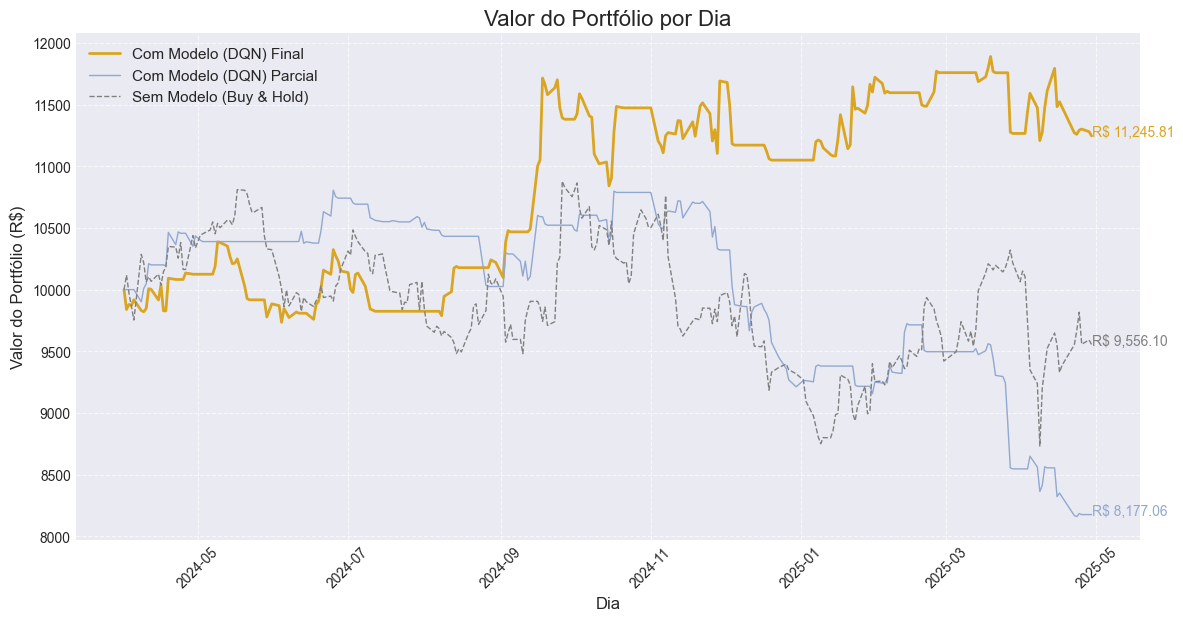

In [142]:
import pandas as pd 

initial_balance = 10000
num_acoes = initial_balance / df_vale['Close'].iloc[0]
portfolio_values_real = df_vale['Close'] * num_acoes

# Garantir que a coluna 'Date' está no formato datetime
df_vale['Date'] = pd.to_datetime(df_vale['Date'])

# Garantir que ambas as listas tenham o mesmo tamanho
min_length = min(len(last_episode_portfolio), len(portfolio_values_real), len(df_vale['Date']))
last_episode_portfolio = last_episode_portfolio[:min_length]
portfolio_values_real = portfolio_values_real[:min_length]
dates = df_vale['Date'][:min_length]

# Estilo do gráfico
plt.style.use('seaborn-v0_8-darkgrid')  

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(dates, last_episode_portfolio, label='Com Modelo (DQN) Final', color='#DAA520', linewidth=2, linestyle='-')
plt.plot(dates, mid_episode_portfolio, label='Com Modelo (DQN) Parcial', color='#91A8D0', linewidth=1, linestyle='-')
plt.plot(dates, portfolio_values_real, label='Sem Modelo (Buy & Hold)', color='gray', linewidth=1, linestyle='--')

# Adicionando título e labels
plt.title("Valor do Portfólio por Dia", fontsize=16)
plt.xlabel("Dia", fontsize=12)
plt.ylabel("Valor do Portfólio (R$)", fontsize=12)

# Adicionando legendas e textos nos pontos finais
plt.legend(loc='best', fontsize=11)
plt.text(dates.iloc[-1], last_episode_portfolio[-1], f'R$ {last_episode_portfolio[-1]:,.2f}', color='#DAA520', fontsize=10)
plt.text(dates.iloc[-1], mid_episode_portfolio[-1], f'R$ {mid_episode_portfolio[-1]:,.2f}', color='#91A8D0', fontsize=10)
plt.text(dates.iloc[-1], portfolio_values_real.iloc[-1], f'R$ {portfolio_values_real.iloc[-1]:,.2f}', color='gray', fontsize=10)

# Adicionando a grade
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustando layout e exibindo o gráfico
plt.tight_layout()
plt.xticks(rotation=45)  # Opcional, para girar as datas e evitar sobreposição
plt.show()
#9862


Episode 10/1000 completed with portfolio of 9527. Com sugestão de ação 1 e recompensa -945.4463.
Episode 20/1000 completed with portfolio of 8289. Com sugestão de ação 0 e recompensa -3422.1969.
Episode 30/1000 completed with portfolio of 7729. Com sugestão de ação 0 e recompensa -4541.2994.
Episode 40/1000 completed with portfolio of 10529. Com sugestão de ação 2 e recompensa 1057.8102.
Episode 50/1000 completed with portfolio of 8156. Com sugestão de ação 1 e recompensa -3688.2127.
Episode 60/1000 completed with portfolio of 8857. Com sugestão de ação 2 e recompensa -2285.4706.
Episode 70/1000 completed with portfolio of 10040. Com sugestão de ação 0 e recompensa 80.9371.
Episode 80/1000 completed with portfolio of 9505. Com sugestão de ação 0 e recompensa -989.6151.
Episode 90/1000 completed with portfolio of 9051. Com sugestão de ação 1 e recompensa -1897.7144.
Episode 100/1000 completed with portfolio of 8481. Com sugestão de ação 1 e recompensa -3037.7433.
Episode 110/1000 comple

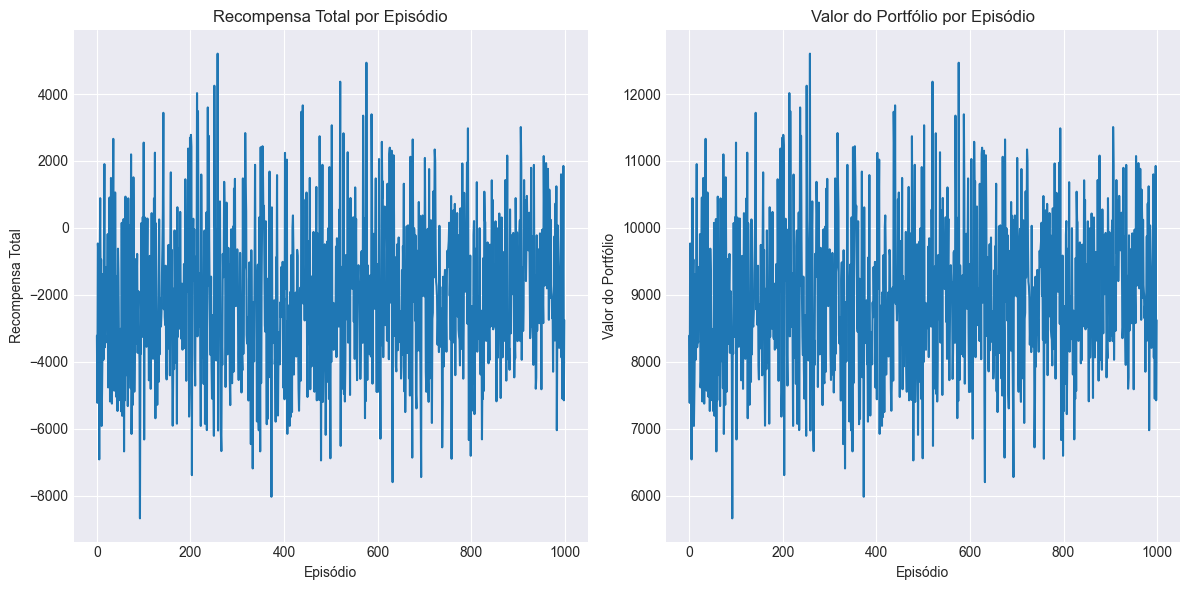

In [78]:
import matplotlib.pyplot as plt

# Definir o tamanho do estado e da ação
state_size = 3  # Preço, saldo, ações
action_size = 3  # Comprar, vender, manter

# Criar o ambiente de negociação
env = TradingEnvironment(df_vale['Close'], initial_balance=10000)

# Criar o agente
agent = DQNAgent(state_size, action_size)

# Listas para armazenar métricas
total_rewards = []  # Para armazenar recompensa total por episódio
portfolio_values = []  # Para armazenar o valor do portfólio no final de cada episódio

# Treinamento
episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    episode_reward = 0  # Recompensa acumulada por episódio
    daily_values = []
    step_count = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        step_count += 1
        if step_count % 1 == 0:
            agent.train()
        state = next_state
        episode_reward += reward  # Acumulando a recompensa no episódio
        if episode == episodes - 1:
            daily_values.append(env.portfolio_value)
            
    last_episode_portfolio = daily_values
    
    # Atualizar a exploração
    agent.update_epsilon()
    
    # Armazenar métricas
    total_rewards.append(episode_reward)
    portfolio_values.append(env.portfolio_value)
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{episodes} completed with portfolio of {round(env.portfolio_value)}. Com sugestão de ação {action} e recompensa {round(episode_reward,4)}.")

# Plotar as métricas
plt.figure(figsize=(12, 6))

# Gráfico de recompensa total por episódio
plt.subplot(1, 2, 1)
plt.plot(total_rewards)
plt.title("Recompensa Total por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Recompensa Total")

# Gráfico do valor do portfólio ao longo dos episódios
plt.subplot(1, 2, 2)
plt.plot(portfolio_values)
plt.title("Valor do Portfólio por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Valor do Portfólio")

plt.tight_layout()
plt.show()


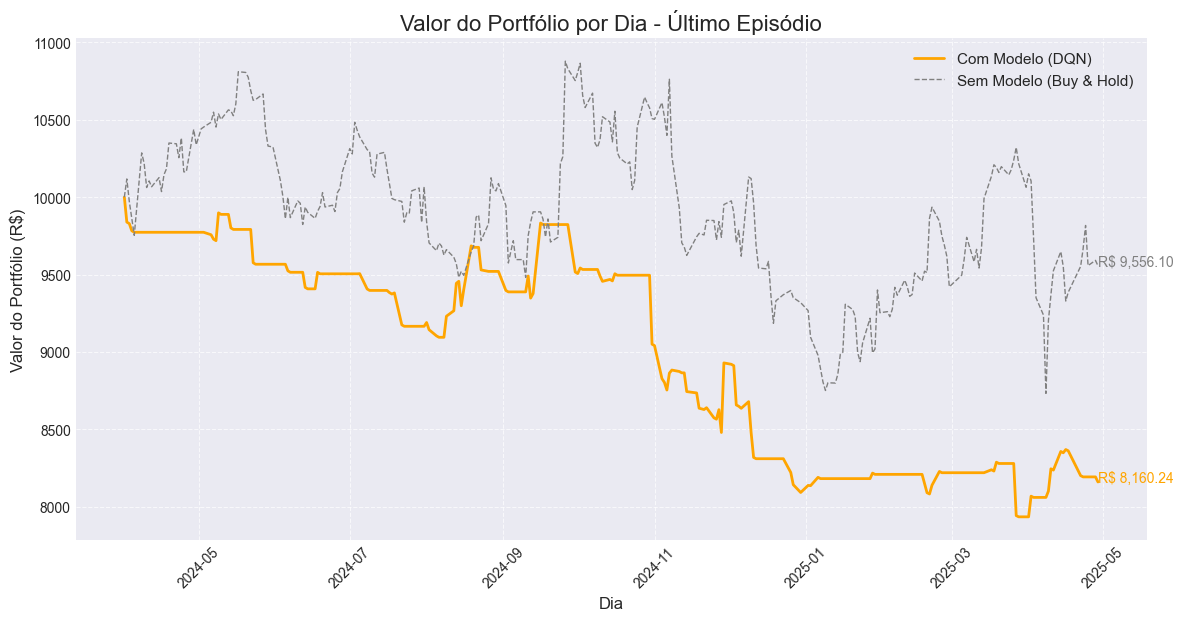

In [75]:
import pandas as pd 

initial_balance = 10000
num_acoes = initial_balance / df_vale['Close'].iloc[0]
portfolio_values_real = df_vale['Close'] * num_acoes

# Garantir que a coluna 'Date' está no formato datetime
df_vale['Date'] = pd.to_datetime(df_vale['Date'])

# Garantir que ambas as listas tenham o mesmo tamanho
min_length = min(len(last_episode_portfolio), len(portfolio_values_real), len(df_vale['Date']))
last_episode_portfolio = last_episode_portfolio[:min_length]
portfolio_values_real = portfolio_values_real[:min_length]
dates = df_vale['Date'][:min_length]

# Estilo do gráfico
plt.style.use('seaborn-v0_8-darkgrid')  

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(dates, last_episode_portfolio, label='Com Modelo (DQN)', color='orange', linewidth=2, linestyle='-')
plt.plot(dates, portfolio_values_real, label='Sem Modelo (Buy & Hold)', color='gray', linewidth=1, linestyle='--')

# Adicionando título e labels
plt.title("Valor do Portfólio por Dia - Último Episódio", fontsize=16)
plt.xlabel("Dia", fontsize=12)
plt.ylabel("Valor do Portfólio (R$)", fontsize=12)

# Adicionando legendas e textos nos pontos finais
plt.legend(loc='best', fontsize=11)
plt.text(dates.iloc[-1], last_episode_portfolio[-1], f'R$ {last_episode_portfolio[-1]:,.2f}', color='orange', fontsize=10)
plt.text(dates.iloc[-1], portfolio_values_real.iloc[-1], f'R$ {portfolio_values_real.iloc[-1]:,.2f}', color='gray', fontsize=10)

# Adicionando a grade
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustando layout e exibindo o gráfico
plt.tight_layout()
plt.xticks(rotation=45)  # Opcional, para girar as datas e evitar sobreposição
plt.show()


# 4.1. Vale

In [76]:
# Split the data into training and testing sets
train_size = int(len(df_vale) * 0.8)
train_data = df_vale[:train_size]
test_data = df_vale[train_size:]

print(f'train_data: {len(train_data)}')
print(f'test_data: {len(test_data)}')

train_data: 220
test_data: 56


In [77]:
import matplotlib.pyplot as plt

# Definir o tamanho do estado e da ação
state_size = 3  # Preço, saldo, ações
action_size = 3  # Comprar, vender, manter

# Criar o ambiente de negociação
env = TradingEnvironment(df_vale['Close'], initial_balance=10000)

# Criar o agente
agent = DQNAgent(state_size, action_size)

# Listas para armazenar métricas
total_rewards = []  # Para armazenar recompensa total por episódio
portfolio_values = []  # Para armazenar o valor do portfólio no final de cada episódio

# Treinamento
episodes = 50
for episode in range(episodes):
    state = env.reset()
    done = False
    episode_reward = 0  # Recompensa acumulada por episódio
    daily_values = []
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward  # Acumulando a recompensa no episódio
        if episode == episodes - 1:
            daily_values.append(env.portfolio_value)
            
    last_episode_portfolio = daily_values
    
    # Atualizar a exploração
    agent.update_epsilon()
    
    # Armazenar métricas
    total_rewards.append(episode_reward)
    portfolio_values.append(env.portfolio_value)
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{episodes} completed with portfolio of {round(env.portfolio_value)}. Com sugestão de ação {action} e recompensa {round(episode_reward,4)}.")

# Plotar as métricas
plt.figure(figsize=(12, 6))

# Gráfico de recompensa total por episódio
plt.subplot(1, 2, 1)
plt.plot(total_rewards)
plt.title("Recompensa Total por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Recompensa Total")

# Gráfico do valor do portfólio ao longo dos episódios
plt.subplot(1, 2, 2)
plt.plot(portfolio_values)
plt.title("Valor do Portfólio por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Valor do Portfólio")

plt.tight_layout()
plt.show()


Episode 10/50 completed with portfolio of 8289. Com sugestão de ação 1 e recompensa -3421.0831.
Episode 20/50 completed with portfolio of 7850. Com sugestão de ação 1 e recompensa -4300.9438.
Episode 30/50 completed with portfolio of 7055. Com sugestão de ação 2 e recompensa -5890.7411.


KeyboardInterrupt: 